In [2]:
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import talos

In [3]:
import pandas as pd
import numpy as np

In [4]:
train = pd.read_csv('Database/train.csv')
test = pd.read_csv('Database/test.csv')

In [5]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100 

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
test.isnull().sum().sum()

0

In [9]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values
comments_train = train['comment_text']
comments_test = test['comment_text']

In [10]:
comments_train = list(comments_train)

Data Cleaning 

In [11]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [12]:
texts = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    texts.append(clean_text(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [13]:
print('Sample data:', texts[1], y[1])

Sample data: aww matches background colour im seemingly stuck thanks talk 2151 january 11 2016  [0 0 0 0 0 0]


In [14]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [15]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 324669


In [16]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [17]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [18]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12102  1262  6705   361  6232  1126]
validation:  [3192  333 1744  117 1645  279]


In [19]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [  225   149  2655  1548 68003   186    50     5  1132   800   296   467
   170 17010   295  2120  5049  4779  4658  1775 14562  9109  3515  6349
 27990   165  3803  2120  5049  1309 14938 25986  1309  1480 31311   378
   295  2120  5049  3044  1424 18958  1480  4658  1135 14562  1844  3515
  6349 14938  6037   466 44869  8067  9495   309  8067 24038  2120  3484
 29747    34  3414  7066   314   742  3674  7645   327   742  3414  6220
  7978  3044  1135 14562  1844  3515 11669 52165  8633 32617  7262 14562
 17331   463     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [20]:
embedding_dim_fasttext = 300
embeddings_index_fasttext = {}
f = open('./embeddings/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


In [22]:

def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(MAX_SEQUENCE_LENGTH, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

#Creating a dictionary of Parameters.

p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

#Initiating GridSearchCV.
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)


  0%|          | 0/18 [00:00<?, ?it/s]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 102s 23ms/step - loss: 0.0758 - accuracy: 0.9550 - val_loss: 0.0631 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 110s 27ms/step - loss: 0.0608 - accuracy: 0.9860 - val_loss: 0.0607 - val_accuracy: 0.9945



  6%|▌         | 1/18 [03:42<1:03:02, 222.50s/it]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 97s 23ms/step - loss: 0.0790 - accuracy: 0.8989 - val_loss: 0.0632 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 98s 24ms/step - loss: 0.0623 - accuracy: 0.9811 - val_loss: 0.0607 - val_accuracy: 0.9945



 11%|█         | 2/18 [06:58<55:10, 206.89s/it]  

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 98s 24ms/step - loss: 0.0752 - accuracy: 0.9155 - val_loss: 0.0624 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 94s 24ms/step - loss: 0.0600 - accuracy: 0.9829 - val_loss: 0.0599 - val_accuracy: 0.9945



 17%|█▋        | 3/18 [10:12<50:16, 201.07s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 99s 24ms/step - loss: 0.0788 - accuracy: 0.9079 - val_loss: 0.0648 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 94s 23ms/step - loss: 0.0616 - accuracy: 0.9895 - val_loss: 0.0595 - val_accuracy: 0.9945



 22%|██▏       | 4/18 [13:26<46:15, 198.27s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 105s 26ms/step - loss: 0.0741 - accuracy: 0.9211 - val_loss: 0.0616 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 94s 24ms/step - loss: 0.0598 - accuracy: 0.9814 - val_loss: 0.0590 - val_accuracy: 0.9944



 28%|██▊       | 5/18 [16:47<43:12, 199.40s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 97s 24ms/step - loss: 0.0790 - accuracy: 0.9418 - val_loss: 0.0622 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 95s 24ms/step - loss: 0.0615 - accuracy: 0.9912 - val_loss: 0.0609 - val_accuracy: 0.9945



 33%|███▎      | 6/18 [20:02<39:31, 197.65s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 101s 25ms/step - loss: 0.0754 - accuracy: 0.8659 - val_loss: 0.0622 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 108s 27ms/step - loss: 0.0601 - accuracy: 0.9836 - val_loss: 0.0606 - val_accuracy: 0.9945



 39%|███▉      | 7/18 [23:31<36:57, 201.56s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 107s 26ms/step - loss: 0.0784 - accuracy: 0.9003 - val_loss: 0.0631 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 99s 25ms/step - loss: 0.0614 - accuracy: 0.9887 - val_loss: 0.0604 - val_accuracy: 0.9945



 44%|████▍     | 8/18 [27:00<33:57, 203.72s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 100s 24ms/step - loss: 0.0738 - accuracy: 0.9465 - val_loss: 0.0617 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 96s 24ms/step - loss: 0.0595 - accuracy: 0.9887 - val_loss: 0.0584 - val_accuracy: 0.9945



 50%|█████     | 9/18 [30:17<30:16, 201.85s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 101s 25ms/step - loss: 0.0798 - accuracy: 0.8980 - val_loss: 0.0628 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 98s 25ms/step - loss: 0.0620 - accuracy: 0.9923 - val_loss: 0.0596 - val_accuracy: 0.9945



 56%|█████▌    | 10/18 [33:39<26:53, 201.68s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 103s 25ms/step - loss: 0.0724 - accuracy: 0.9340 - val_loss: 0.0617 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 100s 25ms/step - loss: 0.0592 - accuracy: 0.9840 - val_loss: 0.0598 - val_accuracy: 0.9941



 61%|██████    | 11/18 [37:04<23:39, 202.82s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 102s 25ms/step - loss: 0.0773 - accuracy: 0.9077 - val_loss: 0.0643 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 92s 23ms/step - loss: 0.0612 - accuracy: 0.9907 - val_loss: 0.0590 - val_accuracy: 0.9945



 67%|██████▋   | 12/18 [40:20<20:03, 200.58s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 104s 25ms/step - loss: 0.0745 - accuracy: 0.9156 - val_loss: 0.0623 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 96s 24ms/step - loss: 0.0599 - accuracy: 0.9899 - val_loss: 0.0594 - val_accuracy: 0.9945



 72%|███████▏  | 13/18 [43:42<16:44, 200.98s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 101s 25ms/step - loss: 0.0767 - accuracy: 0.8836 - val_loss: 0.0623 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 101s 25ms/step - loss: 0.0616 - accuracy: 0.9912 - val_loss: 0.0595 - val_accuracy: 0.9945



 78%|███████▊  | 14/18 [47:05<13:27, 201.79s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 105s 26ms/step - loss: 0.0727 - accuracy: 0.9178 - val_loss: 0.0623 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 97s 24ms/step - loss: 0.0595 - accuracy: 0.9827 - val_loss: 0.0593 - val_accuracy: 0.9941



 83%|████████▎ | 15/18 [50:29<10:07, 202.38s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 103s 25ms/step - loss: 0.0774 - accuracy: 0.8782 - val_loss: 0.0630 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 96s 24ms/step - loss: 0.0609 - accuracy: 0.9844 - val_loss: 0.0591 - val_accuracy: 0.9945



 89%|████████▉ | 16/18 [53:50<06:43, 201.98s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 97s 24ms/step - loss: 0.0733 - accuracy: 0.9311 - val_loss: 0.0632 - val_accuracy: 0.9893
Epoch 2/2
3990/3990 [==============================] - 99s 25ms/step - loss: 0.0601 - accuracy: 0.9891 - val_loss: 0.0594 - val_accuracy: 0.9944



 94%|█████████▍| 17/18 [57:07<03:20, 200.59s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 103s 25ms/step - loss: 0.0757 - accuracy: 0.9199 - val_loss: 0.0628 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 101s 25ms/step - loss: 0.0615 - accuracy: 0.9841 - val_loss: 0.0601 - val_accuracy: 0.9945



100%|██████████| 18/18 [1:00:33<00:00, 201.85s/it]


In [24]:
# Define the LSTM Model.
inp=Input(shape=(MAX_SEQUENCE_LENGTH, ),dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

#Compile the Model.
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#Fit the Model on Training Data.
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))


Epoch 1/2
3990/3990 [==============================] - 79s 19ms/step - loss: 0.0771 - accuracy: 0.8955 - val_loss: 0.0632 - val_accuracy: 0.9945
Epoch 2/2
3990/3990 [==============================] - 92s 23ms/step - loss: 0.0619 - accuracy: 0.9837 - val_loss: 0.0604 - val_accuracy: 0.9945


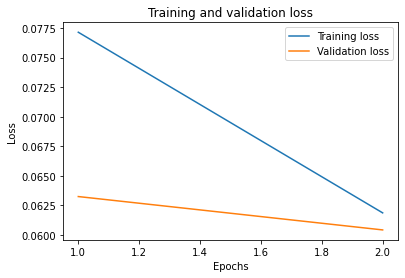

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("train_val_loss_plot")

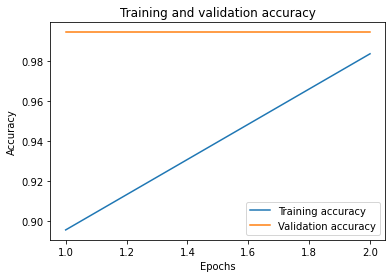

<Figure size 432x288 with 0 Axes>

In [30]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();
plt.savefig("train_val_accuracy_plot")